In [ ]:
#!pip install --use-feature=2020-resolver quantstats

In [14]:
import investpy as ip
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import quantstats as qs
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [15]:
today = datetime.today().date().strftime('%d/%m/%Y')
#start_of_year = f'1/1/{datetime.today().date().year}'
start_of_year = '15/3/2020'

In [16]:
#== Felipe ==#
stocks = ['PETR4', 'MGLU3', 'CYRE3', 'Fundo de Invest Ishares SP 500']
amounts = [600, 400, 300, 200]
types = ['stock','stock',,'stock','etf']

SyntaxError: invalid syntax (<ipython-input-16-4161f29769a9>, line 4)

In [17]:
def get_prices(list_of_assets, list_of_types):
    
    assert len(list_of_assets) == len(list_of_types)
    print(f'Total number of iterations: {len(list_of_assets)}')
    
    output, success, fail = {}, 0, 0
    for i, asset in tqdm(enumerate(list_of_assets)):
         
        try:

            if list_of_types[i] == 'stock':
                p = ip.get_stock_historical_data(asset,
                                                 country='brazil', 
                                                 from_date=start_of_year, to_date=today).Close
            elif list_of_types[i] == 'etf':
                p = ip.get_etf_historical_data(asset,
                                                 country='brazil', 
                                                 from_date=start_of_year, to_date=today).Close
            else:
                p = []

            assert len(p) > 0
            if len(p) >= 20:
                output[asset] = p
                success += 1
            else:
                fail += 1
        except:
            fail += 1
    
    output = pd.DataFrame(output)
    print(f'{success}, {fail}')
    return(output)



### Current portfolio

In [5]:
#Current portfolio
current_portfolio_stocks = get_prices(stocks, types)
current_portfolio_stocks.head()

0it [00:00, ?it/s]

Total number of iterations: 4


4it [00:03,  1.14it/s]

4, 0


,PETR4,MGLU3,CYRE3,Fundo de Invest Ishares SP 500
Date,,,,
2020-03-16,13.09,8.50,16.06,129.22
2020-03-17,13.00,8.87,15.86,136.50
2020-03-18,11.29,7.19,12.59,133.50
2020-03-19,12.21,7.62,13.84,131.25
2020-03-20,12.00,7.65,13.34,125.00


In [6]:
current_portfolio = current_portfolio_stocks.apply(lambda x: x.dot(amounts), axis=1)

In [7]:
current_portfolio.head()

Date
2020-03-16    41916.0
2020-03-17    43406.0
2020-03-18    40127.0
2020-03-19    40776.0
2020-03-20    39262.0
dtype: float64

In [8]:
current_portfolio_returns = current_portfolio.pct_change()
current_portfolio_returns.head()

Date
2020-03-16         NaN
2020-03-17    0.035547
2020-03-18   -0.075543
2020-03-19    0.016174
2020-03-20   -0.037130
dtype: float64

### Get Benchmark

In [9]:
bench = current_portfolio_stocks['Fundo de Invest Ishares SP 500']

### Analysis of current portfolio

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2020-03-16  2020-03-16
End Period                 2021-05-28  2021-05-28
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          88.91%      84.88%
CAGR%                      69.91%      66.88%

Sharpe                     2.3         2.13
Sortino                    3.76        3.65
Sortino/√2                 2.66        2.58

Max Drawdown               nan%        -13.79%
Longest DD Days            -           -
Volatility (ann.)          24.62%      25.88%
R^2                        0.53        0.53
Calmar                     6.03        6.76
Skew                       0.87        0.74
Kurtosis                   12.37       2.98

Expected Daily %           0.21%       0.21%
Expected Monthly %         4.33%       4.18%
Expected Yearly %          37.44%      35.97%
Kelly Criterion            18.63%   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-18,2020-03-23,2020-03-25,7,-11.588260,-9.547067
2,2021-02-18,2021-05-12,2021-05-28,99,-7.636774,-7.480253
3,2020-08-27,2020-09-21,2020-10-13,47,-7.252781,-6.787032
4,2020-10-14,2020-10-30,2020-11-10,27,-5.873182,-5.536547
5,2021-01-11,2021-01-29,2021-02-12,32,-4.667916,-4.337119


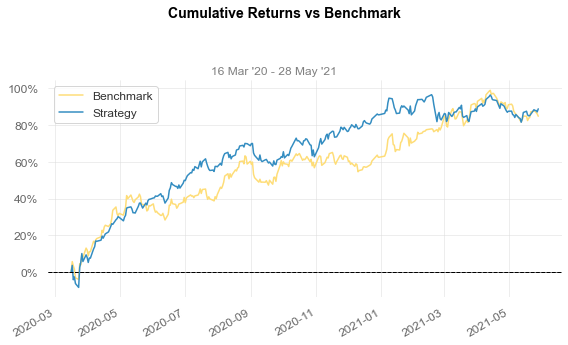

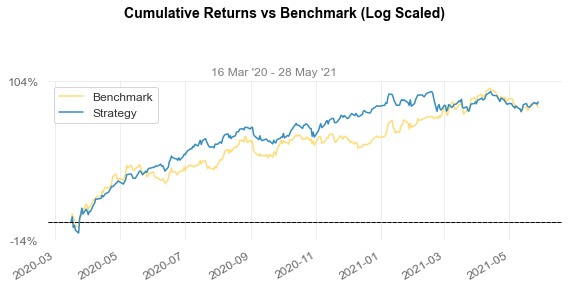

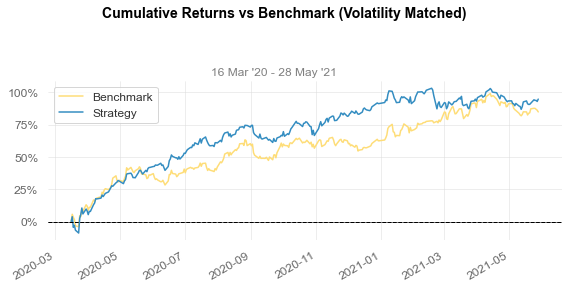

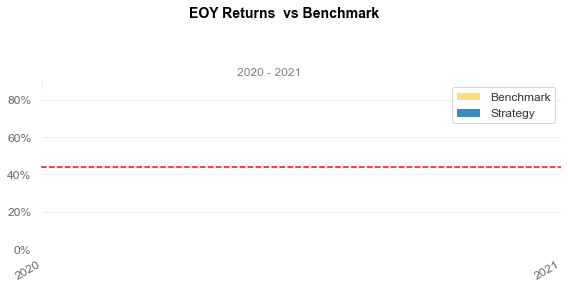

AttributeError: module 'seaborn' has no attribute 'histplot'

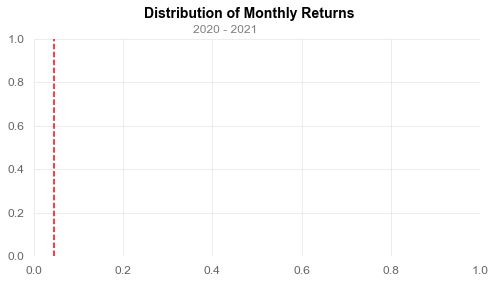

In [18]:
qs.reports.full(current_portfolio_returns, benchmark=bench)

### Get data from new potential stocks

In [ ]:
#candidates
#candidates = list(ip.get_stocks(country='brazil').symbol)
#candidates_types = ['stock' for i in range(len(candidates))]

In [ ]:
#Liquid candidates
temp = ip.get_stocks_overview('brazil', n_results=700)
liquidity_threshold = np.quantile(temp.turnover, .75) #75-th percentile
candidates = temp[temp.turnover >= liquidity_threshold]
candidates = list(candidates.symbol)

In [ ]:
#sample_size = 100
#candidates = candidates[0:sample_size]
#candidates_types = candidates_types[0:sample_size]

In [ ]:
# Candidate stocks prices
candidates_df = get_prices(candidates, list_of_types = ['stock' for i in candidates])
candidates_df.head()

### Loop over all stocks

In [11]:
def new_portfolio(new_stock_prices, new_stock_amount, cp_prices = current_portfolio):
    return(cp_prices + new_stock_prices * new_stock_amount)

In [12]:
#Current portfolio performance#
current_perf = qs.stats.sortino(current_portfolio)
current_perf

3.7572159806115466

In [13]:
opt_new_stock, opt_new_port, opt_perf, log = None, None, -np.inf, []

for c in tqdm(candidates_df.columns):
    
    candidate_stock_price = candidates_df[c]
    candidate_portfolio = new_portfolio(candidate_stock_price, new_stock_amount=100)
    candidate_portfolio_returns = candidate_portfolio.pct_change()
    perf = qs.stats.sortino(candidate_portfolio_returns)
    
    if perf > opt_perf:
        opt_new_stock = c
        opt_new_port = candidate_portfolio
        opt_perf = perf
    
    log.append(perf)

NameError: name 'candidates_df' is not defined

In [ ]:
output = pd.DataFrame([], columns = ['sharpe','sortino'])
output

In [ ]:
for c in tqdm(candidates_df.columns):
    
    candidate_stock_price = candidates_df[c]
    time_in_mkt = len(candidate_stock_price.dropna())/len(candidates_df)
    
    #Only considered stocks that have been in the market for at least 99% of time
    if time_in_mkt >= 0.99:
    
        candidate_portfolio = new_portfolio(candidate_stock_price, new_stock_amount=100)
        candidate_portfolio_returns = candidate_portfolio.pct_change()
        output.loc[c, 'sharpe'] = qs.stats.sharpe(candidate_portfolio_returns)
        output.loc[c, 'sortino'] = qs.stats.sortino(candidate_portfolio_returns)
    
    else:
        pass

In [ ]:
output.sort_values('sortino', ascending=False).head(10)

In [ ]:
output.sort_values('sharpe', ascending=False).head()

In [ ]:
#== Make best new portfolio ==#
best_new_stock_index = 0
best_new_stock = output.sort_values('sortino', ascending=False).index[best_new_stock_index]
best_new_stock_prices = candidates_df[best_new_stock]
best_new_portfolio = new_portfolio(best_new_stock_prices, new_stock_amount=100)
print(best_new_stock)

In [ ]:
qs.plots.snapshot(best_new_stock_prices, title=f'{best_new_stock} Performance')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(output.sortino)
plt.axvline(x=current_perf, c='red');

In [ ]:
qs.reports.full(best_new_portfolio, benchmark=current_portfolio_returns)

In [ ]:
qs.plots.rolling_sharpe(best_new_portfolio, period=60)

In [ ]:
qs.plots.rolling_sortino(best_new_portfolio, period=60)